# Tutorial 5: Integration of spatial transcriptomics and proteomics human lymph node slices

This tutorial demonstrates STAMO’s ablility to integrate spatial transcriptomics (Xenium, 377-gene panel) and proteomics (CODEX, 28-marker antibody panel) slices with limited overlap features (15 shared features). The raw RNA and Protein data can be downloaded from https://www.10xgenomics.com/datasets/human-lymph-node-preview-data-xenium-human-multi-tissue-and-cancer-panel-1-standard and https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Human_Lymph_Node, respectively. The processed datasets are in https://drive.google.com/drive/folders/1tLao5t21Stjcx_8OMmaMOg3TEidpYoeC?usp=drive_link

In [1]:
import warnings
warnings.filterwarnings('ignore')

import anndata as ad
import networkx as nx
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.sparse as sp
from itertools import chain

import STAMO

## Step 1: Data preprocessing

In [2]:
datadir = '/mnt/disk2/xzhou/code/pycharm_ATAC/STAMO_v0/data/Protein/'
adata_protein = sc.read_h5ad(datadir+'Human_Lymph_CODEX.h5ad')
adata_rna = sc.read_h5ad(datadir+'Human_Lymph_RNA_377gene_wlabel_clean.h5ad')

adata_rna.X = sp.csr_matrix(adata_rna.X)
adata_protein.X = sp.csr_matrix(adata_protein.X)
adata_rna.var_names_make_unique()
adata_protein.var_names_make_unique()

adata_rna.var_names = adata_rna.var_names.str.upper()
adata_protein.var_names = adata_protein.var_names.str.upper()

adata_rna.layers['counts'] = adata_rna.X.astype(int).copy()
adata_protein.layers['counts'] = adata_protein.X.astype(int).copy()

adata_rna.obs_names = adata_rna.obs_names+'_rna'
adata_protein.obs_names = adata_protein.obs_names+'_protein'

In [3]:
STAMO.utils.Cal_Spatial_Net(adata_rna, rad_cutoff=10)  # the spatial network are saved in adata.uns[‘adj’]
STAMO.utils.Cal_Spatial_Net(adata_protein, rad_cutoff=25)

------Calculating spatial graph...
The graph contains 2779798 edges, 377897 cells.
7.3560 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 822058 edges, 188450 cells.
4.3622 neighbors per cell on average.


In [4]:
adata_rna.X.max(), adata_protein.X.max(), adata_rna.shape, adata_protein.shape

(79.0, 64982.855, (377897, 377), (188450, 28))

In [5]:
sc.pp.normalize_total(adata_rna) #, target_sum=1e4
sc.pp.log1p(adata_rna)
adata_rna.X = sp.csr_matrix(adata_rna.X)
adata_rna.obsm['X_feat'] = adata_rna.X.toarray().copy()  ## for imaging-based platforms with small gene panel, include all genes as input

sc.pp.normalize_total(adata_protein) #, target_sum=1e4
sc.pp.log1p(adata_protein)
adata_protein.X = sp.csr_matrix(adata_protein.X)
adata_protein.obsm['X_feat'] = adata_protein.X.toarray().copy()

### Prior feature graph construction

To link features across RNA and Protein slices, protein names were manually converted to their corresponding coding gene names based on established protein-gene relationships.

In [6]:
### include as many gene-protein mappings as you can
correspondence = pd.read_csv(datadir + 'protein_gene_conversion.csv')

custom_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    curr_protein_name, curr_rna_names = curr_protein_name.upper(), curr_rna_names.upper()
    if curr_protein_name not in adata_protein.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_rna.var_names:
            custom_correspondence.append([curr_protein_name, r])

custom_correspondence = np.array(custom_correspondence)

custom_correspondence = pd.DataFrame(custom_correspondence, columns=['Protein_name','RNA_name'])
custom_correspondence = custom_correspondence.drop_duplicates(subset=['Protein_name'])
custom_correspondence = custom_correspondence.drop_duplicates(subset=['RNA_name'])


common_gene = adata_rna.var_names.intersection(adata_protein.var_names) ## gene and protein have the same names
correspondence_comm = np.array([common_gene, common_gene]).T

correspondence_add = [['COLLAGENIV','COL4A1'], ['ECAD','CDH1'], 
                     ['SMACTIN','ACTA2'], ['CD45RO','PTPRCAP'], ['PANCK','KRT19'], 
                     ['LY6C','LY6C1'],['F480','ADGRE1'],['ERTR7','COL6A1'], ['TER119','GYPA'],
                     ['NKP46','NCR1'],['B220','PTPRC']]  ### custom protein-gene mappings

custom_correspondence = np.concatenate([correspondence_comm, custom_correspondence.values, correspondence_add])
custom_correspondence = pd.DataFrame(custom_correspondence, columns=['Protein_name','RNA_name']).drop_duplicates().values
custom_correspondence = pd.DataFrame(custom_correspondence, columns=['Protein_name','RNA_name'])

custom_correspondence = custom_correspondence[custom_correspondence['Protein_name'].isin(adata_protein.var.index)]
custom_correspondence = custom_correspondence[custom_correspondence['RNA_name'].isin(adata_rna.var.index)]
print(custom_correspondence.shape)  ## columns=['Protein_name','RNA_name']

(15, 2)


In [7]:
# Define the protein-gene network

guidance =nx.MultiDiGraph()
for ii in range(custom_correspondence.shape[0]): ## protein-gene loop
    k, v = custom_correspondence.iloc[ii, :]
    guidance.add_edge(k, v, weight=1.0, sign=1,  type="rev")
    guidance.add_edge(v, k, weight=1.0, sign=1,  type="fwd")

for item in adata_rna.var_names: ## self-loop
    guidance.add_edge(item, item, weight=1.0, sign=1, type="loop")
for item in adata_protein.var_names:
    guidance.add_edge(item, item, weight=1.0, sign=1, type="loop")

## Step 2: Model training

In [8]:
vertices = sorted(guidance.nodes)

STAMO.models.configure_dataset(adata_rna, "NB", use_highly_variable=False, use_rep="X_feat", use_layer="counts",  use_obs_names=True)
STAMO.models.configure_dataset(adata_protein, "NB", use_highly_variable=False, use_rep="X_feat", use_layer="counts",  use_obs_names=True)

In [9]:
model = STAMO.models.train(
    {"RNA": adata_rna, "Protein": adata_protein}, guidance,
    fit_kws={"directory": "outputs/Protein"}, OT_pair=[('RNA','Protein')]    ### compile_kws={"lam_align": 0.05}
)

[WARNING] STAMOModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] STAMOModel: Setting `graph_batch_size` = 150
[INFO] STAMOModel: Setting `max_epochs` = 48
[INFO] STAMOModel: Setting `patience` = 4
[INFO] STAMOModel: Setting `reduce_lr_patience` = 2
[INFO] STAMOTrainer: Using training directory: "outputs/Protein/pretrain"
[INFO] STAMOTrainer: [Epoch 10] train={'g_nll': 0.13, 'g_kl': 0.129, 'g_elbo': 0.259, 'x_RNA_nll': 0.249, 'x_RNA_kl': 0.007, 'x_RNA_elbo': 0.256, 'x_Protein_nll': 7.095, 'x_Protein_kl': 0.125, 'x_Protein_elbo': 7.22, 'dsc_loss': 0.684, 'vae_loss': 7.494, 'gen_loss': 7.46, 'cos_loss': 0.0, 'gate_rec_loss': 7.557}, val=None, 270.8s elapsed
[INFO] STAMOTrainer: [Epoch 20] train={'g_nll': 0.127, 'g_kl': 0.129, 'g_elbo': 0.256, 'x_RNA_nll': 0.249, 'x_RNA_

2025-06-28 03:48:48,096 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "24"...
[INFO] EarlyStopping: Restoring checkpoint "24"...
[INFO] train: FGW OT mapping from source RNA to Protein
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...


[WARNING] STAMOModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] STAMOModel: Setting `graph_batch_size` = 150
[INFO] STAMOModel: Setting `align_burnin` = 8
[INFO] STAMOModel: Setting `max_epochs` = 48
[INFO] STAMOModel: Setting `patience` = 4
[INFO] STAMOModel: Setting `reduce_lr_patience` = 2
[INFO] STAMOTrainer: Using training directory: "outputs/Protein/fine-tune"
[INFO] STAMOTrainer: [Epoch 10] train={'g_nll': 0.129, 'g_kl': 0.126, 'g_elbo': 0.255, 'x_RNA_nll': 0.251, 'x_RNA_kl': 0.007, 'x_RNA_elbo': 0.258, 'x_Protein_nll': 7.09, 'x_Protein_kl': 0.125, 'x_Protein_elbo': 7.215, 'dsc_loss': 0.668, 'vae_loss': 7.491, 'gen_loss': 7.457, 'cos_loss': 0.003, 'gate_rec_loss': 7.596}, val=None, 218.3s elapsed
Epoch 00013: reducing learning rate of group 0 to 2.0000e-04.
Epoch 00013: reducing learning rate of group 0 to 2.000

2025-06-28 06:21:48,085 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "19"...
[INFO] EarlyStopping: Restoring checkpoint "19"...


In [10]:
adata_rna.obsm["X_STAMO"] = model.encode_data_minibatch("RNA", adata_rna)
adata_protein.obsm["X_STAMO"] = model.encode_data_minibatch("Protein", adata_protein)

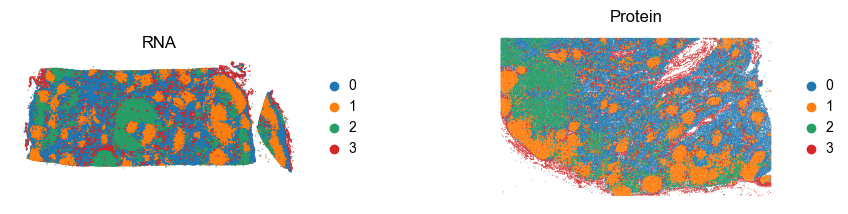

In [11]:
combined = ad.concat([adata_rna, adata_protein], label='omics_type', keys=['RNA','Protein'])
sc.pp.neighbors(combined, use_rep="X_STAMO", metric="cosine")
sc.tl.leiden(combined, random_state=666, key_added="leiden", resolution=0.15)

adata_rna.obs['leiden'] = combined.obs['leiden_res0.2'][combined.obs['omics_type']=='RNA'].values
adata_protein.obs['leiden'] = combined.obs['leiden_res0.2'][combined.obs['omics_type']=='Protein'].values

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.6, 'hspace': 0.1})

sc.pl.spatial(adata_rna, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=30,title='RNA', ax=ax[0])
sc.pl.spatial(adata_protein, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=30,title='Protein',ax=ax[1])

plt.show()

IOStream.flush timed out
IOStream.flush timed out


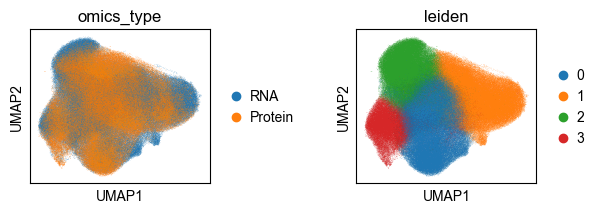

In [12]:
sc.tl.umap(combined)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
sc.pl.umap(combined, color=["omics_type", 'leiden'], wspace=0.65) #, 'mclust' , 'my_annotation'